# Imports

## Import packages

### Packages used in this notebook
* os for file handling
* numpy for image storage and general array handling
* matplotlib for visualisation

### Additional Packages used in dropprocessing module
#### drop_processing.py
* opencv-python for image handling
* math
* scipy.optimize for least squares optimization
* scipy.stats for linear regression

#### file_management.py
* json for easy reading and writing of config files
* re for pattern matching

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import dropprocessing.analysis as vis
import dropprocessing.dimensionless as dimless
import dropprocessing.drop_processing as drop_proc
import dropprocessing.file_management as files
import dropprocessing.image_processing as im_proc
import dropprocessing.physical_quantities as phys_quant

# Image File Handling

## Download example data
The following line checks whether you already downloaded the ~70MB of image data and downloads and unpacks it for you if you did not. If the cell does not seem to proceed, check for an input prompt.

If you do not want a script downloading files for you, you can download and unpack the files yourself from here: https://s.kit.edu/dropimpactexamplesets

In [2]:
files.load_example_sets()

Example sets already downloaded and unpacked!


## Load image data

An example dataset has been provided in the subdirectory "example_set". "parameters.json" contains metadata regarding the experiment.
All required metadata and processing settings are directly loaded into the kernel for easier access.

### Specify data set, load images, metadata and set specific processing settings.

Note: The image files for the different processing steps are saved in different lists rather than overwritten. This is done to prevent issues in the case of single cell reruns.
If you want or need to save memory, set the flag "save_ram" to True so the old lists get deleted regularly.

In [3]:
data_dir = "example_sets"

data_set = "amorphous-carbon"
settings_name = data_set

data_set_path = os.path.join(data_dir, data_set)

dt, t, images, metadata = files.load_data_set(data_set_path)
data_set_settings = files.load_data_set_settings(settings_name)

example_image_idx = 50  # image as a visualisation example
save_ram = False

### Unpack metadata and processing settings

In [4]:
px_p_m = 1e3 * metadata["px_per_mm"]

coarse_crop_default_frame = {
    "left": 0,
    "right": 0,
    "top": 0,
    "bottom": 0
}

coarse_crop_frame = data_set_settings.get("coarse_crop_frame_size",
                                          coarse_crop_default_frame)
outside_px_to_keep = data_set_settings.get("center_droplet_outside_px_to_keep",
                                           20)
center_cols_to_omit = data_set_settings.get("split_images_center_cols_to_omit",
                                             40)


### Fetch required physical quantities (f(T))

In [5]:
T = metadata["temperature"]
rho = phys_quant.density_water(T)
sigma = phys_quant.surface_tension_water(T)
mu = phys_quant.dynamic_viscosity_water(T)
g = phys_quant.g()

# Preprocessing

## Coarse cropping

Hand cropping of data sets to delete unneccessary image information that might slow down or disturb the evaluation of the drop data.


In [6]:
images_coarse_crop = im_proc.coarse_crop(images, **coarse_crop_frame)

### Visualise coarse cropping

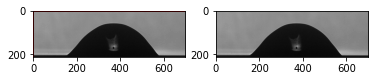

In [7]:
def show_coarse_crop(imbefore, imafter, top, left, right, bottom):

    imwidth = imbefore.shape[1]
    imheight = imbefore.shape[0]

    width = imwidth - left - right + 1
    height = imheight - top - bottom + 1

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(imbefore, cmap="gray")
    rect = patches.Rectangle((left, top), width, height, linewidth=1,
                            edgecolor="r", facecolor="none")
    axs[0].add_patch(rect)

    axs[1].imshow(imafter, cmap="gray")
    plt.show()

imbefore = images[example_image_idx]
imafter = images_coarse_crop[example_image_idx]
show_coarse_crop(imbefore, imafter, **coarse_crop_frame)

del imbefore, imafter
if save_ram:
    del images

## Normalize images
Images are stored in 16bit TIFF format. The camera used to record the images (pco 1200hs) only has a dynamic range of 10 bit. Therefore, the images are appearing to be black in most normal image display tools.

All images are normalized to $v = \left[0; 1\right]$ by dividing every pixel greyscale value by $2^{10}$ (dynamic range).

In [8]:
images_normalized = im_proc.normalize_images(images_coarse_crop,
                                             dynamic_range=10)

if save_ram:
    del images_coarse_crop

## Create Background Image

Reconstruct background by finding the brightest value for each row over the whole image series.

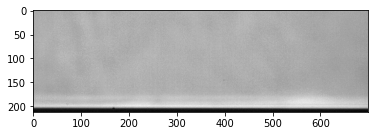

0.3349609375

In [9]:
bg = im_proc.create_bg(images_normalized)

plt.imshow(bg, cmap="gray")
plt.show()

np.max(bg)

## Detect Ground

Detect ground row by calculating vertical grayscale gradient and finding maximal value.

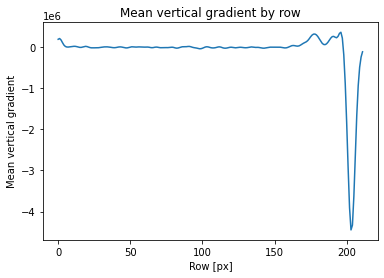

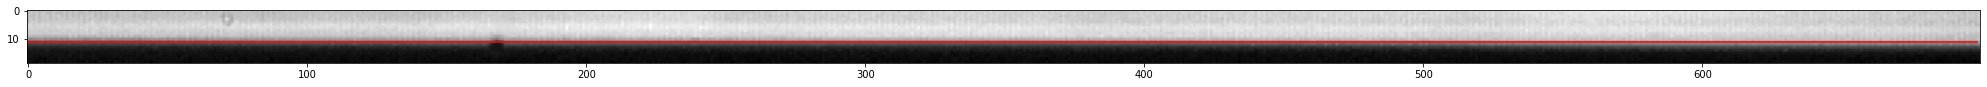

Ground row is located at 203 px.


In [10]:
ground_row_idx = im_proc.detect_ground(bg, visualise=True)

imheight = bg.shape[0]

plt.imshow(bg[imheight - 20:imheight-1, :], cmap="gray")
plt.gca().hlines(ground_row_idx-imheight+20, 0, bg.shape[1]-1, colors="red")
plt.gcf().set_size_inches((35,20))
plt.show()

del imheight

print(f"Ground row is located at {ground_row_idx} px.")

## Cut ground

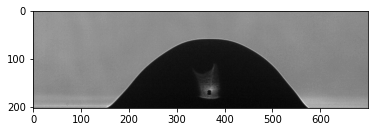

In [11]:
images_cut_ground = im_proc.cut_ground_rows(images_normalized,
                                            ground_row=ground_row_idx)
bg_cut_ground = im_proc.cut_ground_rows([bg], ground_row=ground_row_idx)[0]

if save_ram:
    del images_normalized, bg

plt.imshow(images_cut_ground[example_image_idx], cmap="gray")
plt.show()

## Center droplet

Center images around droplet by finding the outermost points of the droplet left and right and cropping a certain margin around it.

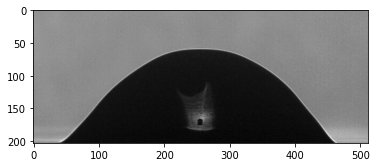

In [12]:
images_centered, leftmost_idx, rightmost_idx = \
    im_proc.center_drop(images_cut_ground, bg_cut_ground,
                        margin=outside_px_to_keep)

if save_ram:
    del images_cut_ground

plt.imshow(images_centered[example_image_idx], cmap="gray")
plt.show()

# Processing

## Find drop impact

Find image with drop impact by analyzing the center of the images.

Impact on image 15.


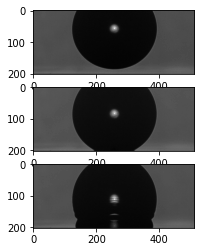

In [13]:
impact_idx = drop_proc.find_drop_impact(images_centered)
print(f"Impact on image {impact_idx}.")

vis.show_images(images_centered, impact_idx, 1, 1)

## Falling velocity

Calculate falling drop velocity by tracking its leading edge 4 frames before impact.

Falling velocity: 0.63 m/s


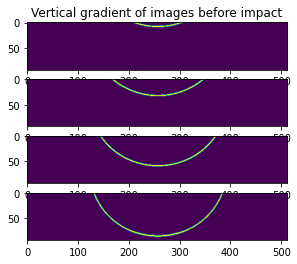

In [14]:
u_fall = drop_proc.calculate_falling_velocity(images_centered, dt, px_p_m,
                                              impact_idx,
                                              visualise=True)

print(f"Falling velocity: {u_fall:.2f} m/s")

## Drop Diameter

Calculate falling drop velocity by tracking its leftmost and rightmost point 4 frames before impact.

In [15]:
d_fall = drop_proc.calculate_drop_diameter(images_centered, px_p_m,
                                           impact_idx)

print(f"Drop diameter: {d_fall*1e3:.2f} mm")

Drop diameter: 2.17 mm


## Calculate contact line positions

Calculate contact line position by finding the (subpixel accurate) position of maximal greyscale gradient on the ground row.

In [25]:
# split images into left and right half, leaving out a margin to omit the high-
# light in the center of the droplet
images_left_half, images_right_half, right_half_offset = \
    im_proc.split_images(images_centered, center_cols_to_omit)

boundaries_left = \
    drop_proc.calculate_boundary_points(images_left_half, impact_idx, 
                                        rows_to_evaluate=5,
                                        boundary_offset=0)
boundaries_right = \
    drop_proc.calculate_boundary_points(images_right_half, impact_idx, 
                                        rows_to_evaluate=5,
                                        boundary_offset=right_half_offset)

# contact line position is defined as lowest boundary point
x_contact_left = np.array([x[-1, 1] for x in boundaries_left])
x_contact_right = np.array([x[-1, 1] for x in boundaries_right])

## Calculate spreading velocity

Spreading velocity in physical units as defined as difference of contact line position between frames.

In [26]:
u_left = -drop_proc.calculate_spreading_velocity(x_contact_left, dt, px_p_m)
u_right = drop_proc.calculate_spreading_velocity(x_contact_right, dt, px_p_m)

## Calculate contact angles

Find the contact angle by fitting a linear function to the drop boundary in the bottom 5 image rows.

In [27]:
theta_left, lin_fits_left = \
    drop_proc.calculate_contact_angles(boundaries_left, 'l')
theta_right, lin_fits_right = \
    drop_proc.calculate_contact_angles(boundaries_right, 'r')

## Visualise contact line positions, spreading velocities and contact angles

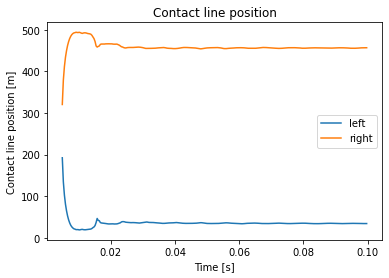

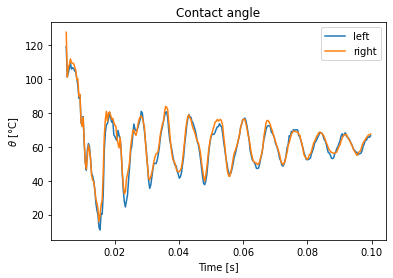

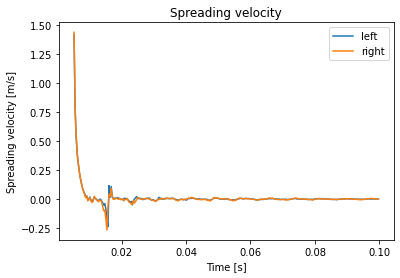

In [29]:
fig, ax = plt.subplots()

ax.plot(t[impact_idx:], x_contact_left)
ax.plot(t[impact_idx:], x_contact_right)

ax.set_title("Contact line position")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Contact line position [m]")

ax.legend(["left", "right"])

fig2, ax2 = plt.subplots()
ax2.plot(t[impact_idx:], theta_left)
ax2.plot(t[impact_idx:], theta_right)

ax2.set_title("Contact angle")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel(r"$\theta$ [°C]")

ax2.legend(["left", "right"])

fig3, ax3 = plt.subplots()

ax3.plot(t[impact_idx+1:], u_left)
ax3.plot(t[impact_idx+1:], u_right)

ax3.set_title("Spreading velocity")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Spreading velocity [m/s]")

ax3.legend(["left", "right"])

plt.show()

del fig, fig2, fig3, ax, ax2, ax3

# Analysis

## Bond number + Weber number

In [33]:
Bo = dimless.bond_number(d_fall, g, rho, sigma)
We = dimless.weber_number(d_fall, u_fall, rho, sigma)
print(f"Weber number: {We}\nBond number: {Bo}")

Weber number: 5.937226127368546
Bond number: 0.15948761988983745


## Calculate spreading factor

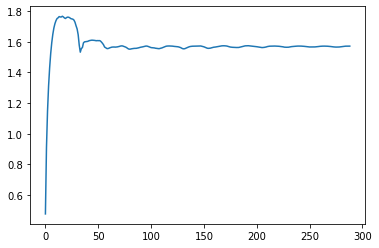

In [32]:
d_star = dimless.spreading_factor(d_fall, x_contact_left, x_contact_right, px_p_m)

plt.plot(d_star)

## Calculate capillary number

In [34]:
Ca_left = dimless.capillary_number(u_left, mu, sigma)
Ca_right = dimless.capillary_number(u_right, mu, sigma)

# Hoffman graph

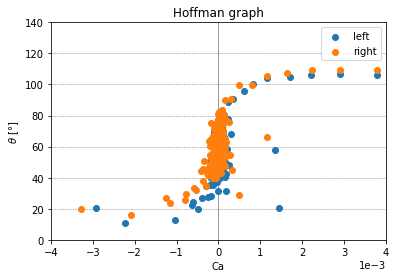

In [39]:
ca_min, ca_max = (-4e-3, 4e-3)
ymin, ymax = (0, 140)

fig, ax = plt.subplots()

ax.scatter(Ca_left, theta_left[1:])
ax.scatter(Ca_right, theta_right[1:])

ax.set_title("Hoffman graph")
ax.set_xlabel("Ca")
ax.set_ylabel(r"$\theta$ [°]")

ax.ticklabel_format(axis='x', scilimits=(-3, -3))

ax.vlines(x = 0, ymin=ymin, ymax=ymax, linestyles="solid",
          linewidth=0.8, color="gray", zorder=-10)
ax.hlines(y=np.arange(20, 140, 20), xmin=ca_min, xmax=ca_max,
          linestyles="dashed", colors="gray", linewidth=0.5, zorder=-5)

ax.set_xlim(ca_min, ca_max)
ax.set_ylim(ymin, ymax)

ax.legend(["left", "right"])

plt.show()

# Save results as CSV

In [42]:
import pandas as pd

data = {
        "t": t[impact_idx+1:],
        "x_left": x_contact_left[1:],
        "x_right": x_contact_right[1:],
        "d_star": d_star[1:],
        "Ca_left": Ca_left,
        "Ca_right": Ca_right,
        "u_left": u_left,
        "u_right": u_right,
        "theta_left": theta_left[1:],
        "theta_right": theta_right[1:]
}

df = pd.DataFrame(data=data)

metadata_out = {}
metadata_out['u_fall'] = u_fall
metadata_out['d_fall'] = d_fall
metadata_out['Bo'] = Bo
metadata_out['We'] = We
metadata_out['dt'] = dt
metadata_out['T'] = T
metadata_out['rho'] = rho
metadata_out['g'] = g
metadata_out['sigma'] = sigma
metadata_out['mu'] = sigma

meta_df = pd.DataFrame(data=metadata_out, index=[0])

outfile_path = os.path.join(data_set_path, "data.csv")
metadata_outfile_path = os.path.join(data_set_path, "metadata.csv")

df.to_csv(outfile_path, index=False)
meta_df.to_csv(metadata_outfile_path, index=False)